In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import cmath
from datetime import datetime
from kneed import KneeLocator
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
from nolitsa import delay
import numpy as np
import os
import pandas as pd
import re
import scipy
from sdeint import itoint
from scipy.integrate import odeint
from scipy.signal import butter, lfilter
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.api import AutoReg, VAR
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

plt.style.use('../../sci_style.py')

sys.path.append('../../..')
from iaaft import surrogates
from dynamical_systems_models import construct_dictionary, embed_signal, perform_stability_analysis, get_stability_results, compute_EDMD, predict_EDMD, compute_VAR_p, compute_VAR_p_over_lamb, predict_VAR_p
from nld_utils import calculate_fnn_stat, get_nn_indices
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

# Chaotic Network

In [3]:
# g_vals = np.hstack([np.arange(0.9, 1.6, 0.02), np.arange(1.6, 2, 0.05)])
# g_vals = np.arange(0.9, 1.61, 0.02)
g_vals = [0.95, 1, 1.1, 1.6]
# g_vals = [1.1, 1.6]
# g_vals = [1.1]

In [7]:
%%time 
def network_deriv(x, t, W, tau, noise=0):
    return (1/tau)*(-x + W @ np.tanh(x) + noise)

# -----------------------------
# PARAMETERS
# -----------------------------
N = 256
dt = 0.01 # s
tau_sim = 10 # ms
noise_sigma = 0.005
num_lags = 500
projection_dim = 10
projection_mat = np.random.randn(N, projection_dim)
total_time = 10

W = np.random.randn(N, N)/np.sqrt(N)

time_vals = np.arange(0, total_time + dt/2, dt)
x0 = np.random.randn(N)*0.5

signal_info = {}

for g in g_vals:

    key = f"g_{g:.3f}"
    W_eff = W*g
    
    print("-"*25)
    print(key)

#     signal_full = np.zeros((len(time_vals), N))
#     signal_full[0] = x0
#     noise_vals = np.random.randn(len(time_vals), N)*noise_sigma
#     for t in tqdm(range(1, len(time_vals))):
#         signal_full[t] = signal_full[t - 1] + (dt*1000)*network_deriv(signal_full[t-1], time_vals[t-1], W_eff, tau_sim, noise=noise_vals[t-1])

    signal_full = itoint(lambda y, t: network_deriv(y, t, W=W_eff, tau=tau_sim*0.001), lambda y, t: np.eye(N)*noise_sigma, x0, time_vals)
    
    #     signals_full[key] = odeint(lambda y, t: network_deriv(y, t, W=W_eff, tau=tau, noise_sigma), x0, time_vals)
    signal = signal_full @ projection_mat


    iterator = tqdm(total=signal.shape[1]*num_lags)
    delayed_mi = np.zeros((signal.shape[1], num_lags))
    for i in range(signal.shape[1]):
        for lag in range(num_lags):
            delayed_mi[i, lag] = delay.mi(signal[lag:, i], signal[:signal.shape[0] - lag, i])
            iterator.update()
    iterator.close()

    mean_delayed_mi = delayed_mi.mean(axis=0)
    tau = KneeLocator(np.arange(num_lags), mean_delayed_mi, S=40, curve='convex', direction='decreasing').knee

    signal_subsampled = signal[np.arange(0, signal.shape[0], tau)]

    signal_info[key] = dict(
        signal=signal,
        signal_full=signal_full,
        signal_subsampled=signal_subsampled,
        delayed_mi=delayed_mi,
        tau=tau,
        N=N,
        W=W,
        g=g,
        dt=dt,
        time_vals=time_vals,
        noise_sigma=noise_sigma,
        projection_mat=projection_mat
    )

-------------------------
g_0.950


  0%|          | 0/5000 [00:00<?, ?it/s]

-------------------------
g_1.000


  0%|          | 0/5000 [00:00<?, ?it/s]

-------------------------
g_1.100


  0%|          | 0/5000 [00:00<?, ?it/s]

-------------------------
g_1.600


  0%|          | 0/5000 [00:00<?, ?it/s]

CPU times: user 6min 46s, sys: 16.2 s, total: 7min 2s
Wall time: 3min 51s


In [ ]:
# pd.to_pickle(signals, '__data__/chaotic_net_signals.pkl')
# pd.to_pickle(signals_full, '__data__/chaotic_net_signals_full.pkl')

# signals = pd.read_pickle('__data__/chaotic_net_signals.pkl')
# signals_full = pd.read_pickle('__data__/chaotic_net_signals_full.pkl')

# Class

In [166]:
class KoopmanModels:
    def __init__(self, signal, p=None, svd=True, verbose=False):
        self.signal = signal
        self.window = signal.shape[0]
        self.n = signal.shape[1]
        self.p = p
        
        if p is not None:
            self.compute_hankel(verbose=verbose)
            if svd:
                self.compute_svd(verbose=verbose)
            else:
                self.U = None
                self.S = None
                self.V = None
                self.S_mat = None
                self.S_mat_inv = None
                self.knee = None
        else:
            self.H = None
        
        self.A_var_p = None
        self.H_var_p = None
        self.eigvals_var_p = None
        
        self.r = None
        self.A_havok_dmd = None
        self.V_havok_dmd = None
        self.H_havok_dmd = None
        self.eigvals_havok_dmd = None
        
#         self.A_havok_forcing = None
#         self.B_havok_forcing = None
#         self.V_havok_forcing = None
#         self.H_havok_forcing = None
        
    def compute_hankel(self, p=None, verbose=False):
        if verbose:
            print("Computing Hankel matrix ...")
        if p is None and self.p is None:
            raise ValueError("Embedding dim p has not been provided.")
        elif p is not None:
            self.p = p
        else: # p is None and self.p is not None
            p = self.p
            
        H = embed_signal(self.signal, p, 1, direction='reverse')
        self.H = H
        
        if verbose:
            print("Hankel matrix computed!")
        
    def compute_svd(self, verbose=False):
        if verbose:
            print("Computing SVD on Hankel matrix ...")
        U, S, Vh = np.linalg.svd(self.H.T, full_matrices=False)
        V = Vh.T
        self.U = U
        self.S = S
        self.V = V

        S_mat = np.zeros(U.shape)
        S_mat[np.arange(len(S)), np.arange(len(S))] = S
        self.S_mat = S_mat
        
        S_mat_inv = np.zeros(U.shape)
        S_mat_inv[np.arange(len(S)), np.arange(len(S))] = 1/S
        self.S_mat_inv = S_mat_inv
        
        self.knee = KneeLocator(np.arange(len(S)), S, S=40, curve='convex', direction='decreasing').knee
        
        if verbose:
            print("SVD complete!")
    
    def compute_var_p(self, verbose=False):
        if verbose:
            print("Computing least squares fit to VAR(p) ...")
        coefs = np.linalg.lstsq(self.H[:-1], self.H[1:, :self.n], rcond=1e-14)[0].T
        if verbose:
            print("Least squares complete!")
            print("Constructing transition matrix and train predictions ...")
        A_mat = np.zeros((self.H.shape[1], self.H.shape[1]))
        for i in range(self.p):
            A_mat[:self.n, :][:, i*self.n:(i + 1)*self.n] = coefs[:, i*self.n:(i + 1)*self.n]
            if i < self.p - 1:
                A_mat[(i + 1)*self.n:(i + 2)*self.n, :][:, i*self.n:(i + 1)*self.n] = np.eye(self.n)
        self.A_var_p = A_mat
        H_var_p = (A_mat @ self.H[:-1].T).T
        self.H_var_p = np.vstack([self.H[[0]], H_var_p])
        if verbose:
            print("Train predictions complete!")
            print("Computing eigenvalues ...")
        
        self.eigvals_var_p = np.linalg.eigvals(A_mat)
    
        if verbose:
            print("Eigenvalues computed!")
            
    def compute_havok_dmd(self, r=None, forcing=False, s=1, verbose=False):
        if verbose:
            print("Computing least squares fit to HAVOK DMD ...")
        if r is None:
            r = self.knee*2
        self.r = r
        
        A = np.linalg.lstsq(self.V[:-1, :r], self.V[1:, :r], rcond=1e-14)[0].T
        self.A_havok_dmd = A
        if verbose:
            print("Least squares complete!")
            print("Computing train predictions ...")
        
        V_havok_dmd = (A @ self.V[:-1, :r].T).T
        V_havok_dmd = np.vstack([self.V[[0], :r], V_havok_dmd])
        self.V_havok_dmd = V_havok_dmd
        H_havok_dmd = (self.U @ self.S_mat[:, :r] @ V_havok_dmd.T).T
        self.H_havok_dmd = H_havok_dmd
        
        if verbose:
            print("Train predictions complete!")
            print("Computing eigenvalues ...")
        
        self.eigvals_havok_dmd = np.linalg.eigvals(A)
    
        if verbose:
            print("Eigenvalues computed!")
            
        if forcing:            
            B = A[:r-s, r-s:r]
            A = A[:r-s, :r-s]
            self.A_havok_forcing = A
            self.B_havok_forcing = B
            
#             # not chained
#             V_havok_forcing = (A @ self.V[:-1, :r-s].T).T + (B @ self.V[:-1, r-s:r].T).T
#             V_havok_forcing = np.vstack([self.V[[0], :r-s], V_havok_forcing])
#             self.V_havok_forcing = V_havok_forcing 
            
            # chained
            V_havok_forcing = np.zeros(koopman.V[:, :r-s].shape)
            V_havok_forcing[0] = koopman.V[0, :r-s]
            for t in range(1, koopman.V.shape[0]):
                V_havok_forcing[t] = A @ V_havok_forcing[t-1] + B @ koopman.V[t-1, r-s:r].T
            self.V_havok_forcing = V_havok_forcing
                
            self.H_havok_forcing = (self.U @ self.S_mat[:, :r-s] @ V_havok_forcing.T).T
            
            self.eigvals_havok_forcing = np.linalg.eigvals(A)
            
    def predict_var_p(self, test_signal, tail_bite=False):
        H_test = embed_signal(test_signal, self.p, 1, direction='reverse') 
        
        if tail_bite:
            pass
        else:
            H_test_var_p = (self.A_var_p @ H_test[:-1].T).T
            H_test_var_p = np.vstack([H_test[[0]], H_test_var_p])
        
        return H_test_var_p, H_test

    def predict_havok_dmd(self, test_signal, tail_bite=False):
        H_test = embed_signal(test_signal, self.p, 1, direction='reverse')
        V_test = (self.S_mat_inv[:self.r] @ self.U.T @ H_test.T).T
        
        if tail_bite:
            pass
        else:
            V_test_havok_dmd = (self.A_havok_dmd @ V_test[:-1].T).T
            V_test_havok_dmd = np.vstack([V_test[[0], :self.r], V_test_havok_dmd])
            H_test_havok_dmd = (self.U @ self.S_mat[:, :self.r] @ V_test_havok_dmd.T).T
        
        return H_test_havok_dmd, H_test, V_test_havok_dmd, V_test

In [338]:
signal = signal_info['g = 1.100']['signal_subsampled']
# signal = (signal - signal.mean(axis=0))/signal.std(axis=0)

In [339]:
signal.shape[0]

9091

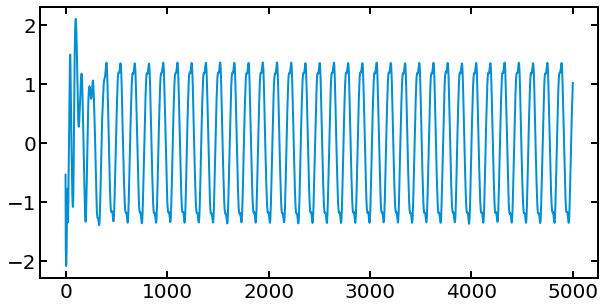

In [321]:
plt.plot(signal[:5000, 0])

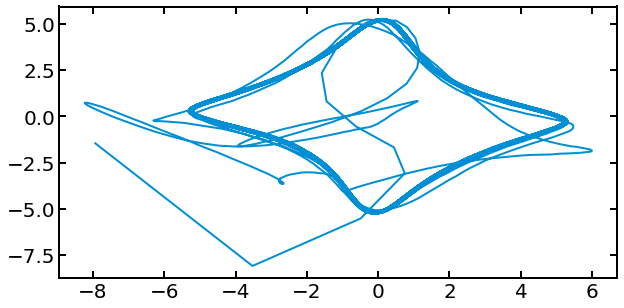

In [322]:
proj1 = np.random.randn(signal.shape[1])
proj2 = np.random.randn(signal.shape[1])
plt.plot(signal @ proj1, signal @ proj2)
plt.show()

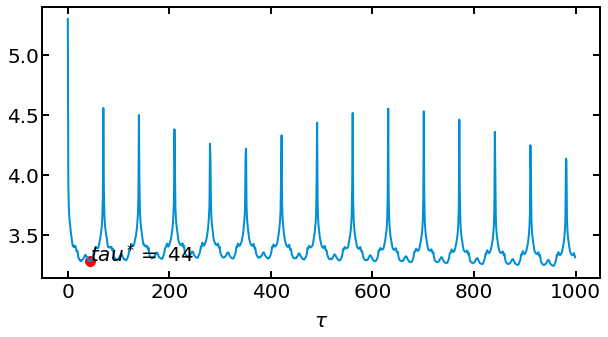

In [325]:
plt.plot(mean_delayed_mi)
plt.scatter(tau, mean_delayed_mi[tau], c='red', s=100)
plt.xlabel(r'$\tau$')
plt.text(tau, mean_delayed_mi[tau], fr"$tau^* = $ {tau}")
plt.show()

In [125]:
# window_start = 1500
# window = 10000
window_start = 10
window = 2100
p = 180
n = signal.shape[1]

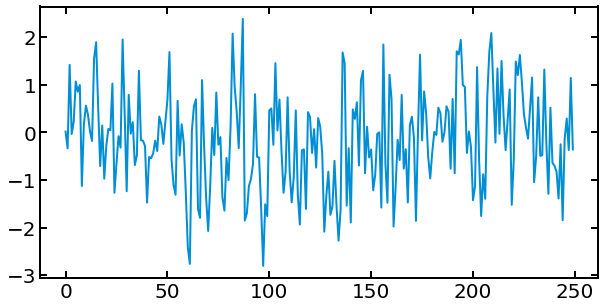

In [126]:
plt.plot(signal_subsampled[:250, 4])
plt.show()

In [127]:
# train_signal = signal[window_start:window_start + window]
train_signal = signal_subsampled[window_start:window_start + window]

In [128]:
%%time
koopman = KoopmanModels(train_signal, p=p, verbose=True)

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
CPU times: user 7.5 s, sys: 140 ms, total: 7.64 s
Wall time: 4.07 s


In [129]:
%%time
koopman.compute_var_p()

CPU times: user 16.6 s, sys: 227 ms, total: 16.8 s
Wall time: 8.45 s


In [130]:
r2_var_p = r2_score(koopman.H[1:, :n], koopman.H_var_p[1:, :n])
r2_persistence_baseline = r2_score(koopman.H[1:, :n], koopman.H[:-1, :n])

In [131]:
T_pred = 500
# test_signal = signal[window_start + window - p:window_start + window + T_pred]
test_signal = signal_subsampled[window_start + window - p:window_start + window + T_pred]

In [132]:
H_test_var_p, H_test = koopman.predict_var_p(test_signal)
r2_var_p_test = r2_score(H_test[1:, :n], H_test_var_p[1:, :n])
r2_persistence_baseline_test = r2_score(H_test[1:, :n], H_test[:-1, :n])

In [133]:
koopman.compute_havok_dmd(r=koopman.knee)
H_test_havok_dmd, H_test, _, _ = koopman.predict_havok_dmd(test_signal)

In [134]:
r2_havok_dmd_test = r2_score(H_test[1:, :n], H_test_havok_dmd[1:, :n])

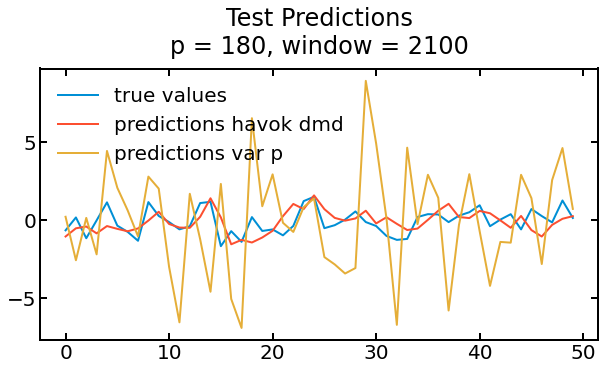

In [135]:
start = 0
end = 50
ind = 0
plt.plot(H_test[1 + start:1 + end, ind], label='true values')
plt.plot(H_test_havok_dmd[1 + start:1 + end, ind], label='predictions havok dmd')
plt.plot(H_test_var_p[1 + start:1 + end, ind], label='predictions var p')
# plt.plot(H_test[:-1, ind], label='persistence baseline', linestyle='--', alpha=0.5)
plt.legend()
# plt.xlim([180, 200])
plt.title(f"Test Predictions\np = {p}, window = {window}")
plt.show()

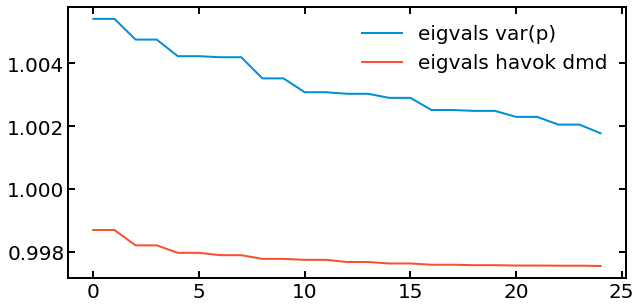

In [136]:
start = 0
end = 25
plt.plot(np.sort(np.abs(koopman.eigvals_var_p))[::-1][start:end], label='eigvals var(p)')
plt.plot(np.sort(np.abs(koopman.eigvals_havok_dmd))[::-1][start:end], label='eigvals havok dmd')
plt.legend()
plt.show()

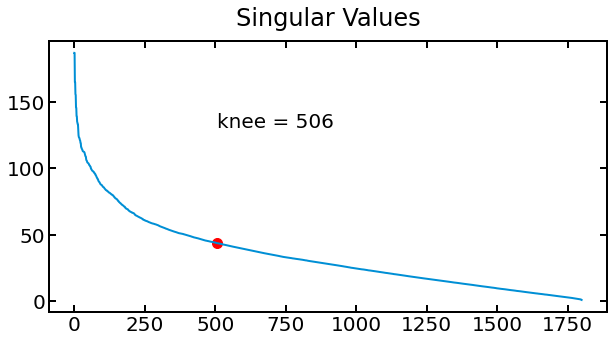

In [137]:
plt.plot(koopman.S)
plt.scatter(koopman.knee, koopman.S[koopman.knee], c='red', s=100)
plt.text(koopman.knee, koopman.S[koopman.knee]*3, f"knee = {koopman.knee}")
plt.title("Singular Values")
plt.show()

In [138]:
r_vals = np.array([int(r) for r in np.linspace(2, koopman.V.shape[1], 30)])

In [139]:
r2_scores = np.zeros(len(r_vals))
r2_scores_test = np.zeros(len(r_vals))
eigvals = []
for i, r in tqdm(enumerate(r_vals), total=len(r_vals)):
    koopman.compute_havok_dmd(r=r)
    r2_scores[i] = r2_score(koopman.H[1:, :n], koopman.H_havok_dmd[1:, :n])
    
    H_test_havok_dmd, _, _, _ = koopman.predict_havok_dmd(test_signal)
    r2_scores_test[i] = r2_score(H_test[1:, :n], H_test_havok_dmd[1:, :n])
    eigvals.append(koopman.eigvals_havok_dmd)

  0%|          | 0/30 [00:00<?, ?it/s]

In [140]:
mean_eigvals = [np.sort(np.abs(vals))[::-1].mean() for vals in eigvals]
mean_eigvals_top_10 = [np.sort(np.abs(vals))[::-1][int(len(vals)/10)].mean() for vals in eigvals]

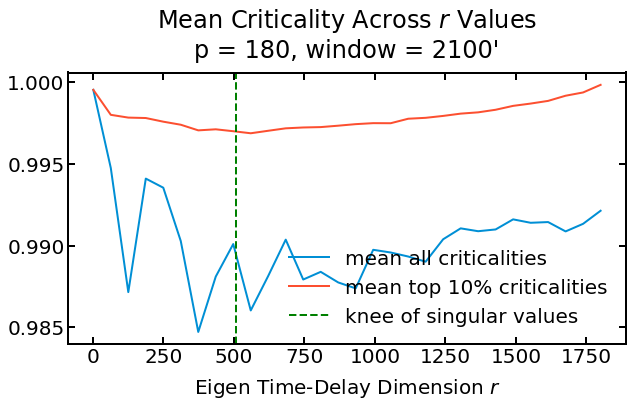

In [141]:
plt.plot(r_vals, mean_eigvals, label='mean all criticalities')
plt.plot(r_vals, mean_eigvals_top_10, label='mean top 10% criticalities')
plt.xlabel('Eigen Time-Delay Dimension $r$')
plt.axvline(koopman.knee, linestyle='--', c='g', label='knee of singular values')
plt.title(f"Mean Criticality Across $r$ Values\np = {p}, window = {window}'")
plt.legend()
plt.show()

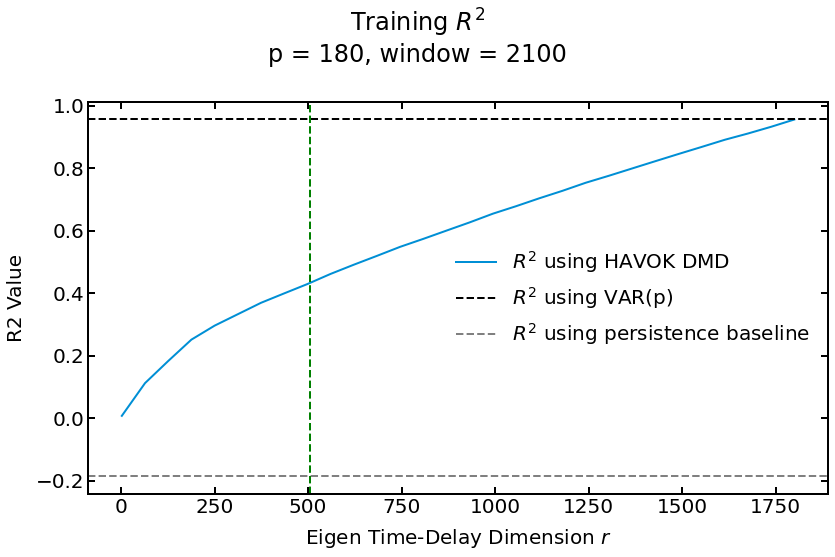

In [142]:
plt.figure(figsize=(12, 8))
plt.plot(r_vals, r2_scores, label='$R^2$ using HAVOK DMD')
plt.axhline(r2_var_p, linestyle='--', c='k', label='$R^2$ using VAR(p)')
plt.axhline(r2_persistence_baseline, linestyle='--', c='gray', label='$R^2$ using persistence baseline')
plt.xlabel('Eigen Time-Delay Dimension $r$')
plt.ylabel('R2 Value')
plt.legend()
plt.suptitle(f'Training $R^2$\np = {p}, window = {window}')
plt.axvline(koopman.knee, linestyle='--', c='g', label='knee of singular values')
plt.tight_layout()
plt.show()

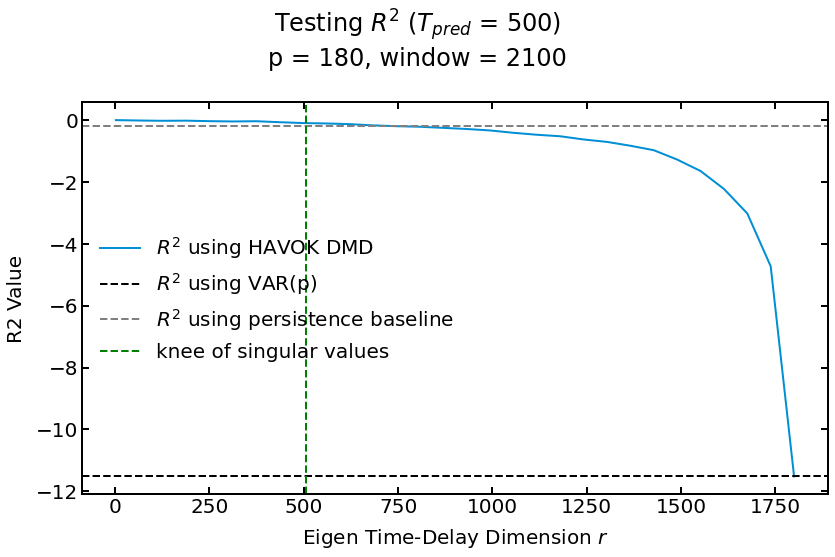

In [143]:
plt.figure(figsize=(12, 8))
plt.plot(r_vals, r2_scores_test, label='$R^2$ using HAVOK DMD')
plt.axhline(r2_var_p_test, linestyle='--', c='k', label='$R^2$ using VAR(p)')
plt.axhline(r2_persistence_baseline_test, linestyle='--', c='gray', label='$R^2$ using persistence baseline')
plt.xlabel('Eigen Time-Delay Dimension $r$')
plt.ylabel('R2 Value')
plt.axvline(koopman.knee, linestyle='--', c='g', label='knee of singular values')
plt.legend()
plt.suptitle('Testing $R^2$ ($T_{pred}$ = ' + f"{T_pred})\np = {p}, window = {window}")

plt.tight_layout()
plt.show()

In [144]:
koopman.S[-1]

0.8022561252752859

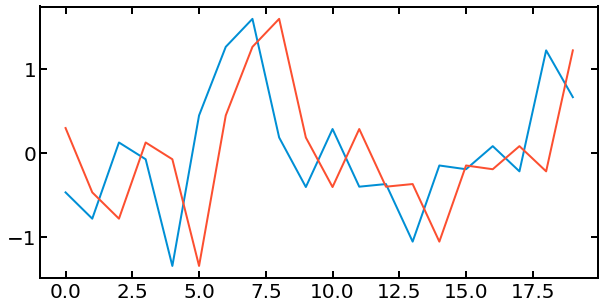

In [145]:
plt.plot(koopman.H[1:21, 0])
plt.plot(koopman.H[0:21-1, 0])